In [1]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip

--2025-12-04 17:28:42--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T18%3A23%3A03Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-04T17%3A22%3A40Z&ske=2025-12-04T18%3A23%3A03Z&sks=b&skv=2018-11-09&sig=eVK0EfTmaoZFarVyKFo4Sy2wWHhjEzdJMf2NxQMwEvw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDg3MTEyMiwibmJmIjoxNzY0ODY5MzIyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG

In [2]:
# Import all the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
from torchsummary import summary

In [3]:
# Reproduciblity settings
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
from PIL import Image
# Load an image of curly hair
img = Image.open('data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')

# Resize to target size
img = img.resize((224, 224))

# Convert to numpy array
x = np.array(img)
print(x.shape)  # (224, 224, 3)

(224, 224, 3)


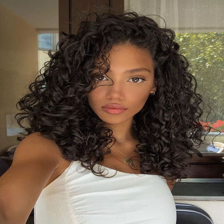

In [6]:
img

In [7]:
# Data transformation
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [8]:
# Define the Datasets and DataLoaders

train_dataset = ImageFolder('./data/train/', transform=train_transforms)
val_dataset = ImageFolder('./data/test', transform=train_transforms)

train_dl = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [9]:
# The CNN model

class HairNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Conv layer: input 3 channels → 32 feature maps
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            padding=0,
            stride=1
        )

        # Max Pooling layer to reduce the input image by half
        self.pool = nn.MaxPool2d(2,2)

        # from formula: 200 -> conv -> 198 -> maxPool -> 99 and channels is equal to number of filters
        flat_out_shape = 32*99*99

        # linear layer
        self.fc1 = nn.Linear(flat_out_shape, 64)

        # binary output
        self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        x = F.relu(self.conv(x))  # Apply conv + relu
        x = self.pool(x)          # Downsample

        x = torch.flatten(x, 1)   # Flatten to (batch, features)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)           # logits output
        return x


### Since we are having raw logits from the last neuron, we will be using `BCEWithLogitsLoss`

In [10]:
# Creating the model, loss and optimizer

model = HairNet().to(device)

lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

In [11]:
# model summary

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


### Clearly, the total params of the model is around 20 million!

In [12]:
# Train 10 epochs without augmentation

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)

        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        predicted = (torch.sigmoid(outputs) > 0.5).float()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train

    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()

    # For the validation data loader
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = lossfn(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val

    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Loss={epoch_loss:.4f} | Acc={epoch_acc:.4f} | "
          f"ValLoss={val_epoch_loss:.4f} | ValAcc={val_epoch_acc:.4f}")


Epoch 1/10 → Loss=0.6665 | Acc=0.6112 | ValLoss=0.6511 | ValAcc=0.6617
Epoch 2/10 → Loss=0.5702 | Acc=0.6787 | ValLoss=0.6332 | ValAcc=0.6318
Epoch 3/10 → Loss=0.5207 | Acc=0.7350 | ValLoss=0.6143 | ValAcc=0.6766
Epoch 4/10 → Loss=0.4773 | Acc=0.7600 | ValLoss=0.6049 | ValAcc=0.6617
Epoch 5/10 → Loss=0.4606 | Acc=0.7550 | ValLoss=0.7307 | ValAcc=0.5672
Epoch 6/10 → Loss=0.3954 | Acc=0.8275 | ValLoss=0.6412 | ValAcc=0.6866
Epoch 7/10 → Loss=0.2844 | Acc=0.8838 | ValLoss=0.8307 | ValAcc=0.6816
Epoch 8/10 → Loss=0.2885 | Acc=0.8788 | ValLoss=0.7052 | ValAcc=0.7114
Epoch 9/10 → Loss=0.1882 | Acc=0.9313 | ValLoss=0.9275 | ValAcc=0.6866
Epoch 10/10 → Loss=0.2585 | Acc=0.8912 | ValLoss=0.8158 | ValAcc=0.6915


In [13]:
# median of training accuracy
tr_median_acc = np.median(history['acc'])

# standard deviation of training loss
tr_std_loss = np.std(history['loss'])

print(f'Median accuracy of training: {tr_median_acc:.3f}')
print(f'Std dev of training loss: {tr_std_loss:.3f}')

Median accuracy of training: 0.794
Std dev of training loss: 0.146


### Median accuracy of training: `0.794`
### Std dev of training loss: `0.146`

In [14]:
# Same model with data augmentation
# We will update the data transforms

aug_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
# Updated dataset and data loaders, apply only on training data!

train_dataset_aug = ImageFolder("data/train", transform=aug_transforms)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=20, shuffle=True)

In [16]:
# Train again for 10 epochs, now with data augmentation

for epoch in range(10):  # more 10 epochs
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset_aug)
    epoch_acc = correct_train / total_train

    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = lossfn(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val

    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"[AUG] Epoch {epoch+1} → "
          f"Loss={epoch_loss:.4f} | Acc={epoch_acc:.4f} | "
          f"ValLoss={val_epoch_loss:.4f} | ValAcc={val_epoch_acc:.4f}")


[AUG] Epoch 1 → Loss=0.6307 | Acc=0.6600 | ValLoss=0.5963 | ValAcc=0.7114
[AUG] Epoch 2 → Loss=0.5801 | Acc=0.6750 | ValLoss=0.5968 | ValAcc=0.7214
[AUG] Epoch 3 → Loss=0.5374 | Acc=0.7175 | ValLoss=0.5870 | ValAcc=0.7015
[AUG] Epoch 4 → Loss=0.5502 | Acc=0.7125 | ValLoss=0.5695 | ValAcc=0.7264
[AUG] Epoch 5 → Loss=0.5250 | Acc=0.7412 | ValLoss=0.6758 | ValAcc=0.6816
[AUG] Epoch 6 → Loss=0.5141 | Acc=0.7612 | ValLoss=0.5764 | ValAcc=0.7313
[AUG] Epoch 7 → Loss=0.5217 | Acc=0.7362 | ValLoss=0.5756 | ValAcc=0.6866
[AUG] Epoch 8 → Loss=0.4888 | Acc=0.7588 | ValLoss=0.5724 | ValAcc=0.7214
[AUG] Epoch 9 → Loss=0.4989 | Acc=0.7475 | ValLoss=0.5452 | ValAcc=0.7313
[AUG] Epoch 10 → Loss=0.4663 | Acc=0.7688 | ValLoss=0.5619 | ValAcc=0.7164


In [17]:
# Losses of augmented part are in history['val_loss'][10:20]
aug_val_losses = history['val_loss'][-10:]
mean_aug_val_loss = np.mean(aug_val_losses)

# Acc of last 5 augmented epochs
last5_acc = history['val_acc'][-5:]
avg_last5 = np.mean(last5_acc)

print("Mean augmented test loss =", mean_aug_val_loss)
print("Avg test acc (last 5 epochs) =", avg_last5)

Mean augmented test loss = 0.58569345893848
Avg test acc (last 5 epochs) = 0.717412935323383


### The mean test loss after augmentation: `0.58`
### Average of last 5 epochs test accuracy: `0.71`

### Augmentation helped the valadation accuracy!